In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
print(np.__version__)

1.16.4


In [2]:
import sys
sys.path.insert(0,'/Users/siyitang/Dropbox/Github/metal')

In [3]:
import metal
print(metal.__version__)

0.5.0


In [4]:
import sys
import os
#os.environ['CUDA_VISIBLE_DEVICES']='0'
import pandas as pd

In [5]:
# Setting data location
eeg_data_path = '/Users/siyitang/Documents/RubinLab/Project/EEG/Data/Reports'
#eeg_data_path = '/home/tsy935/Docs/RubinLab/Data/EEG/Reports'
eeg_data_file = 'reports_unique_for_hl_mm_multiclassLabels.csv'
data_path = os.path.join(eeg_data_path, eeg_data_file)

# Loading data
df_eeg = pd.read_csv(data_path, index_col=0).dropna(how='all')

# Rename the column names
print(df_eeg.columns.values)

['note_uuid' 'note_date' 'edf_file_name' 'start_dt' 'end_dt' 'birth_date'
 'EEG report' 'note' 'seizureScore' 'hand_label' 'EEG report.1'
 'Notes (e.g. sw = spike wave, (hyps)arrhythmia, poss sz, polyspike bursts)'
 'Unnamed: 14' 'Unnamed: 15' 'multiclass_label_abnormal'
 'multiclass_label_seizure' 'multiclass_label_slowing'
 'multiclass_label_spikes' 'multiclass_label_sharps'
 'multiclass_label_suppression' 'multiclass_label_discont'
 'multiclass_label_hypsar' 'multiclass_label_seizure_motor'
 'multiclass_label_seizure_hyperkinetic' 'multiclass_label_seizure_tonic'
 'multiclass_label_seizure_clonic']


In [6]:
# Testing a single EEGNote
from eeg_utils import EEGNote
noteObj = EEGNote(df_eeg['note_uuid'][100], df_eeg['note'][100])

In [7]:
# Use the more general function to parse EEG doc
import dill
from eeg_utils import parse_eeg_docs_multiclass

# Parsing documents -- note that 1 = abnormal, 2 = others
column_names = ['multiclass_label_abnormal','multiclass_label_seizure', 'multiclass_label_slowing', 
                'multiclass_label_spikes', 'multiclass_label_sharps', 'multiclass_label_suppression', 
                'multiclass_label_discont','multiclass_label_hypsar', 'multiclass_label_seizure_motor', 
                'multiclass_label_seizure_hyperkinetic',
               'multiclass_label_seizure_clonic', 'multiclass_label_seizure_tonic']

eeg_note_dill = 'parsed_eeg_notes.dill'
eeg_note_dill_path = os.path.join(eeg_data_path, eeg_note_dill)

if os.path.exists(eeg_note_dill_path):
    print('Loading pre-parsed EEG notes...')
    with open(eeg_note_dill_path, 'rb') as af:
        docs = dill.load(af)
else:
    print('Parsing EEG notes...')
    docs = parse_eeg_docs_multiclass(df_eeg, column_names, use_dask=False)
    with open(eeg_note_dill_path,'wb') as af:
        dill.dump(docs, af)

Loading pre-parsed EEG notes...


In [8]:
# These are docs with empty sections -- most look like they're not EEG reports!
from eeg_utils import get_empty_docs
empty_docs = get_empty_docs(docs)

In [9]:
# Removing empty EEG docs
eeg_docs = list(set(docs)-set(empty_docs))
print(f'Number of EEG Reports with Sections: {len(eeg_docs)}')

Number of EEG Reports with Sections: 10303


In [10]:
import numpy as np
from eeg_utils import create_data_split_multiclass

# Shuffling and setting seed
np.random.seed(123)
np.random.shuffle(eeg_docs)

# Creating data split
train_docs, dev_docs, test_docs = create_data_split_multiclass(eeg_docs, column_names)
docs_list = [train_docs, dev_docs, test_docs]

In [11]:
Y_dev = []
Y_test = []

# Computing dev/test label balance for each class
for i, col_name in enumerate(column_names):
    curr_Y_dev = np.array([doc.gold_label[col_name] for doc in dev_docs])
    curr_Y_test = np.array([doc.gold_label[col_name] for doc in test_docs])
    Y_dev.append(curr_Y_dev)
    Y_test.append(curr_Y_test)

print('Y_dev length:{}'.format(len(Y_dev)))
print('Y_dev task 0:{}'.format(Y_dev[0]))

dev_balance = np.zeros((len(column_names)))
test_balance = np.zeros((len(column_names)))

for i in range(len(column_names)):
    dev_balance[i] = np.sum(Y_dev[i] == 1) /len(Y_dev[i])
    test_balance[i] = np.sum(Y_test[i] == 1)/len(Y_test[i])
    print(f'Class {i+1} dev positive percentage: {dev_balance[i]}')
    print(f'Class {i+1} test positive percentage: {test_balance[i]}\n')

Y_dev length:12
Y_dev task 0:[1. 1. 2. 2. 2. 1. 2. 1. 2. 1. 1. 2. 1. 1. 1. 1. 2. 2. 1. 2. 1. 1. 1. 1.
 2. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 2. 1. 1. 1. 2. 1. 2. 1. 1. 2. 2. 2.
 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 1. 2. 2. 2. 1. 2. 2. 1. 2. 1. 2. 1. 1. 2.
 2. 2. 1. 1. 1. 2. 2. 1. 1. 1. 1. 2. 1. 1. 2. 2. 1. 1. 1. 1. 2. 1. 1. 2.
 2. 2. 2. 2. 1. 1. 1. 1. 2. 1. 1. 1. 2. 1. 1. 1. 2. 2. 1. 1. 1. 1. 2. 1.
 2. 1. 1. 2. 1. 1. 2. 1. 1. 1. 2. 1. 2. 1. 2. 1. 1. 1. 2. 2. 1. 1. 1. 2.
 2. 2. 2. 1. 1. 1. 1. 2. 2. 1. 2. 1. 1. 2. 2. 1. 1. 1. 1. 1. 2. 2. 1. 1.
 2. 1. 1. 2. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1.
 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 2. 1. 1. 1. 1. 1. 1. 2. 1. 1.
 2. 2. 1. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 2. 1. 2. 1. 2. 1.
 1. 2. 1. 1. 1. 1. 2. 1. 1. 2. 2. 1. 1. 2. 1. 1. 2. 1. 2. 1. 1. 2.]
Class 1 dev positive percentage: 0.6106870229007634
Class 1 test positive percentage: 0.6045627376425855

Class 2 dev positive percentage: 0.1984732824427481
Class 2 test po

In [12]:
import re
from eeg_lfs_multiclass import *
from eeg_utils import get_section_with_name

In [13]:
from metal.analysis import single_lf_summary, confusion_matrix
column_names = ['multiclass_label_abnormal','multiclass_label_seizure', 'multiclass_label_slowing', 
                'multiclass_label_spikes', 'multiclass_label_sharps', 'multiclass_label_suppression', 
                'multiclass_label_discont','multiclass_label_hypsar', 'multiclass_label_seizure_motor', 
                'multiclass_label_seizure_hyperkinetic',
               'multiclass_label_seizure_clonic', 'multiclass_label_seizure_tonic']

# Testing single LF
class_idx = 0
lf_test = lf_findall_abnormal_interp

# Computing labels
Y_lf = np.array([lf_test(doc) for doc in dev_docs])
single_lf_summary(Y_lf, Y=Y_dev[class_idx])

,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
0,"[1, 2]",0.996183,0.0,0.0,253,8,0.969349


In [14]:
# Print confusion matrix
conf = confusion_matrix(Y_dev[class_idx], Y_lf)

        y=1    y=2   
 l=1    155     4    
 l=2     4     98    


In [15]:
# 12 tasks
# task 0: {ABNORMAL, NORMAL}
# task 1: {SEIZURE, OTHER_ABNORMAL, NOT_APPLICABLE}
# task 2: {SLOWING, OTHER_ABNORMAL, NOT_APPLICABLE}
# task 3: {SPIKES, OTHER_ABNORMAL, NOT_APPLICABLE}
# task 4: {SHARPS, OTHER_ABNORMAL, NOT_APPLICABLE}
# task 5: {SUPPRESSION, OTHER_ABNORMAL, NOT_APPLICABLE}
# task 6: {DISCONTINUITY, OTHER_ABNORMAL, NOT_APPLICABLE}
# task 7: {HYPSAR, OTHER_ABNORMAL, NOT_APPLICABLE}
# task 8:{MOTOR_SEIZURE, OTHER_ABNORMAL, NOT_APPLICABLE}
# task 9: {HYPER_SEIZURE, OTHER_ABNORMAL, NOT_APPLICABLE}
# task 10: {CLONIC_SEIZURE, OTHER_ABNORMAL, NOT_APPLICABLE}
# task 11: {TONIC_SEIZURE, OTHER_ABNORMAL, NOT_APPLICABLE}

# UNUSED:     
    #lf_normal_interp_not_seizure,
    #lf_findall_abnl_interp_without_seizure,   
    #lf_seizure_section,
    #lf_impression_section_negative,
    #lf_impression_section_positive,
    #lf_extreme_words_in_impression,

lfs = [
    [lf_abnormal_interp,
    lf_findall_abnormal_interp,
    lf_normal_interp],   
    
    
    [lf_abnormal_interp_with_seizure,
    lf_findall_interp_with_seizure,
    lf_seizure_section],

    
    [lf_abnormal_interp_with_slowing,
    lf_findall_interp_with_slowing,
    lf_slowing_in_impression],
    
    [lf_abnormal_interp_with_spikes,
    lf_findall_interp_with_spikes,
    lf_spikes_in_impression],
    
    [lf_abnormal_interp_with_sharps,
    lf_findall_interp_with_sharps,
    lf_sharps_in_impression],
    
    [lf_abnormal_interp_with_suppression,
    lf_findall_interp_with_suppression,
    lf_suppression_in_impression],
    
    [lf_abnormal_interp_with_discont,
    lf_findall_interp_with_discont,
    lf_discont_in_impression],
    
    [lf_abnormal_interp_with_hypsarrhythmia,
    lf_findall_interp_with_hypsarrhythmia,
    lf_hypsarrhythmia_in_impression],
    
    [lf_seizure_motor,
    lf_findall_seizure_motor,
    lf_seizure_motor_in_sections],
    
    [lf_seizure_hyperkinetic,
    lf_findall_seizure_hyperkinetic,
    lf_seizure_hyperkinetic_in_sections],
    
    [lf_seizure_clonic,
    lf_findall_seizure_clonic,
    lf_seizure_clonic_in_sections],
    
    [lf_seizure_tonic,
    lf_findall_seizure_tonic,
    lf_seizure_tonic_in_sections]]

NUM_TASKS = len(column_names)
print(NUM_TASKS)

12


In [16]:
from scipy.sparse import csr_matrix
import dask
from dask.diagnostics import ProgressBar
from eeg_utils import evaluate_lf_on_docs, create_label_matrix
import pickle

# Resetting LFs
clobber_lfs = True
Ls_file = 'Ls_0p3.pkl'
Ys_file = 'Ys_0p3.pkl'

# Get lf names
#lf_names = [lf.__name__ for lf in lfs]
lf_names = [[lf.__name__ for lf in curr_lfs] for curr_lfs in lfs]

# Loading Ls if they exist

Ls = [] # Ls is a t-dim list of (n,m) sparse matrices
Ys = [] # Ys is a t-dim list of (n,) ground truth labels
if clobber_lfs or (not os.path.exists(Ls_file)):
    print('Computing label matrices...')
    for i, docs in enumerate([train_docs, dev_docs, test_docs]):
        split_Ls = []
        for j in range(NUM_TASKS):
            curr_Ls = create_label_matrix(lfs[j],docs)
            split_Ls.append(curr_Ls)
        #for j in range(NUM_TASKS):           
        #    split_Ls.append(curr_Ls)
        Ls.append(split_Ls)
            
    with open(Ls_file,'wb') as af:
        pickle.dump(Ls, af)
    
else:
    print('Loading pre-computed label matrices...')
    with open(Ls_file,'rb') as af:
        Ls=pickle.load(af) 
    
# Create Ys
print('Creating label vectors...')
Ys = [[],Y_dev, Y_test]
with open(Ys_file,'wb') as af:
    pickle.dump(Ys, af)

Computing label matrices...
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  5.2s
[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  2.1s
[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  1.0s
[########################################] | 100% Completed |  7.7s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[###################

In [17]:
# Check Ls shape
L_train = Ls[0]
L_dev = Ls[1]
Y_dev = Ys[1]
for j in range(len(L_dev)):
    print('L_dev task {} shape: {}'.format(j, L_dev[j].shape))
    print('Y_dev task {} shape: {}'.format(j, Y_dev[j].shape))


L_dev task 0 shape: (262, 3)
Y_dev task 0 shape: (262,)
L_dev task 1 shape: (262, 3)
Y_dev task 1 shape: (262,)
L_dev task 2 shape: (262, 3)
Y_dev task 2 shape: (262,)
L_dev task 3 shape: (262, 3)
Y_dev task 3 shape: (262,)
L_dev task 4 shape: (262, 3)
Y_dev task 4 shape: (262,)
L_dev task 5 shape: (262, 3)
Y_dev task 5 shape: (262,)
L_dev task 6 shape: (262, 3)
Y_dev task 6 shape: (262,)
L_dev task 7 shape: (262, 3)
Y_dev task 7 shape: (262,)
L_dev task 8 shape: (262, 3)
Y_dev task 8 shape: (262,)
L_dev task 9 shape: (262, 3)
Y_dev task 9 shape: (262,)
L_dev task 10 shape: (262, 3)
Y_dev task 10 shape: (262,)
L_dev task 11 shape: (262, 3)
Y_dev task 11 shape: (262,)


In [18]:
# Majority vote for each class
from metal.label_model.baselines import MajorityLabelVoter

mv = MajorityLabelVoter(seed=123)
#scores = mv.score((Ls[1][0], Ys[1][0]), metric=['accuracy','precision', 'recall', 'f1'])

for task_idx in range(NUM_TASKS):
    print('Majority Label Voter Metrics for Class {}:'.format(task_idx))
    print(Ls[1][task_idx].shape)
    print(Ys[1][task_idx].shape)
    scores = mv.score((Ls[1][task_idx], Ys[1][task_idx]), metric=['accuracy','precision', 'recall', 'f1'])

Majority Label Voter Metrics for Class 0:
(262, 3)
(262,)
Accuracy: 0.973
Precision: 0.981
Recall: 0.975
F1: 0.978
        y=1    y=2   
 l=1    156     3    
 l=2     4     99    
Majority Label Voter Metrics for Class 1:
(262, 3)
(262,)
Accuracy: 0.805
Precision: 0.506
Recall: 0.865
F1: 0.638
        y=1    y=2   
 l=1    45     44    
 l=2     7     166   
Majority Label Voter Metrics for Class 2:
(262, 3)
(262,)
Accuracy: 0.966
Precision: 0.933
Recall: 0.966
F1: 0.949
        y=1    y=2   
 l=1    84      6    
 l=2     3     169   
Majority Label Voter Metrics for Class 3:
(262, 3)
(262,)
Accuracy: 0.939
Precision: 0.926
Recall: 0.806
F1: 0.862
        y=1    y=2   
 l=1    50      4    
 l=2    12     196   
Majority Label Voter Metrics for Class 4:
(262, 3)
(262,)
Accuracy: 0.981
Precision: 0.903
Recall: 0.933
F1: 0.918
        y=1    y=2   
 l=1    28      3    
 l=2     2     229   
Majority Label Voter Metrics for Class 5:
(262, 3)
(262,)
Accuracy: 1.000
Precision: 1.000
Reca

In [26]:
Y_dev = Ys[1]
Y_test = Ys[2]

print(len(Y_dev))
print(Y_dev[0].shape)

12
(262,)


In [27]:
from metal.analysis import lf_summary

# Analyzing LF stats
task_idx = 9
print(column_names[task_idx])
df_lf = lf_summary(Ls[1][task_idx], Y=Y_dev[task_idx], lf_names=lf_names[task_idx])
df_lf

multiclass_label_seizure_hyperkinetic


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
lf_seizure_hyperkinetic,0,"[1, 2]",0.904580,0.904580,0.003817,237,0,1.000000
lf_findall_seizure_hyperkinetic,1,"[1, 2]",0.996183,0.996183,0.003817,261,0,1.000000
lf_seizure_hyperkinetic_in_sections,2,"[1, 2]",0.996183,0.996183,0.003817,260,1,0.996169


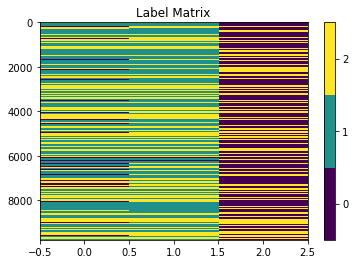

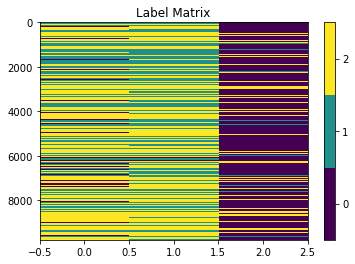

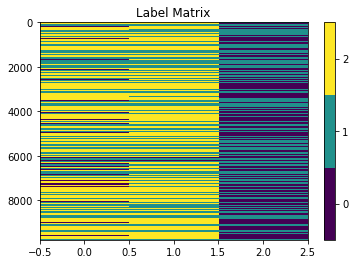

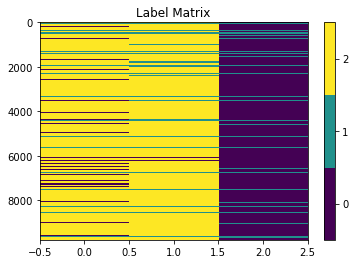

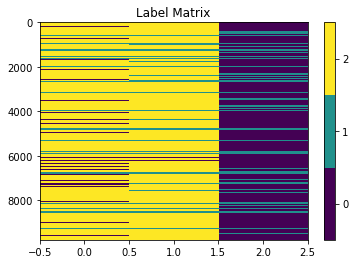

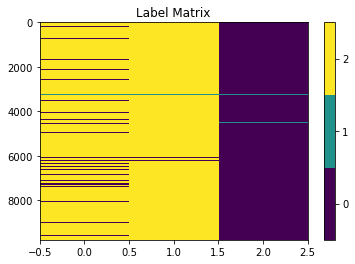

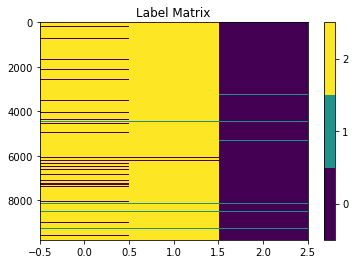

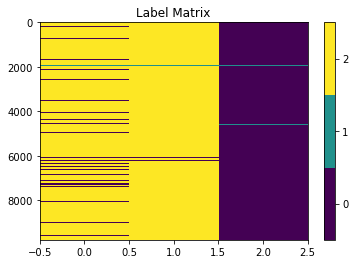

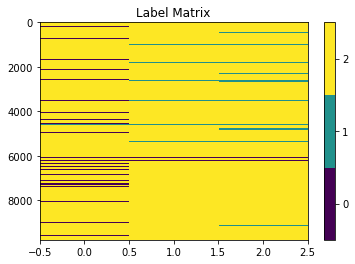

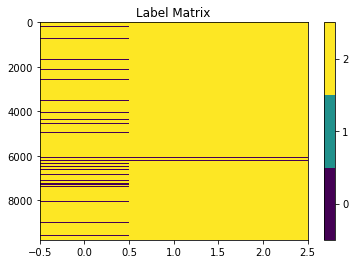

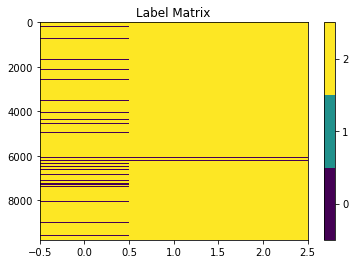

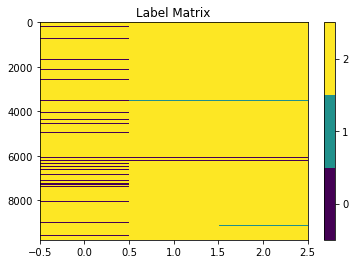

In [28]:
from metal.contrib.visualization.analysis import view_label_matrix, view_overlaps

# Viewing label matrix
for j in range(NUM_TASKS): 
    view_label_matrix(Ls[0][j])

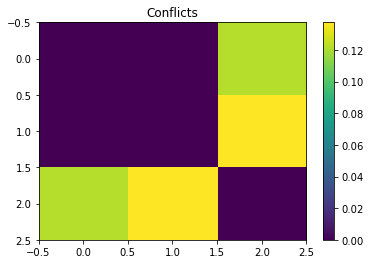

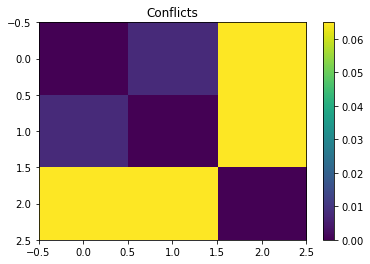

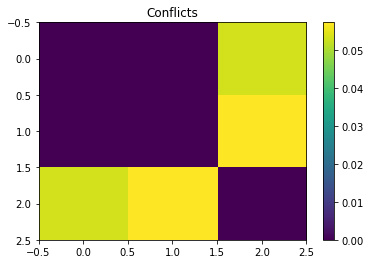

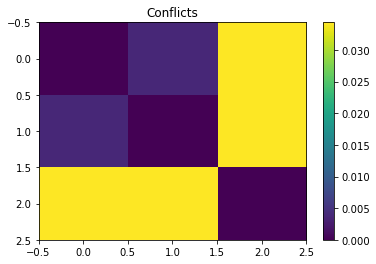

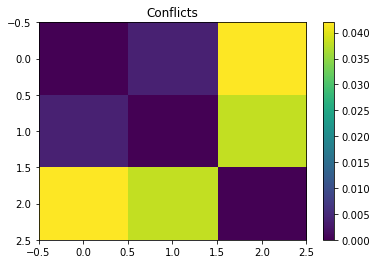

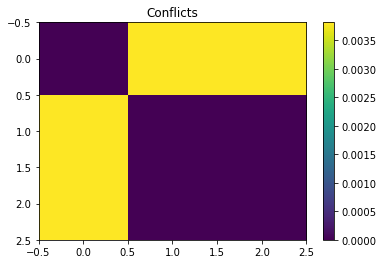

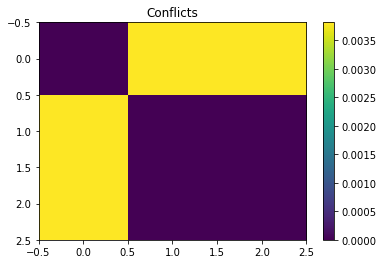

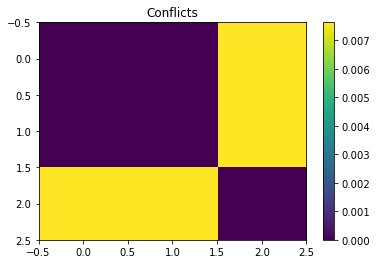

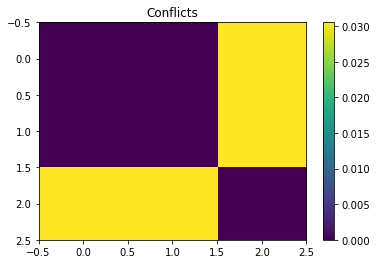

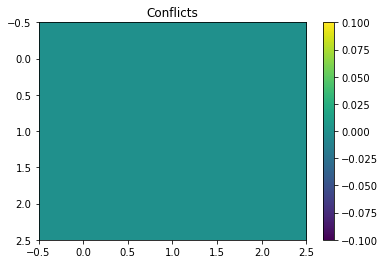

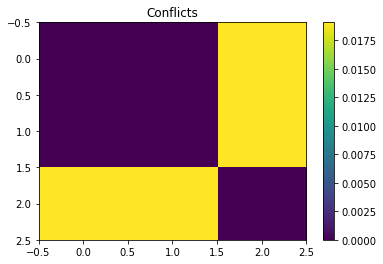

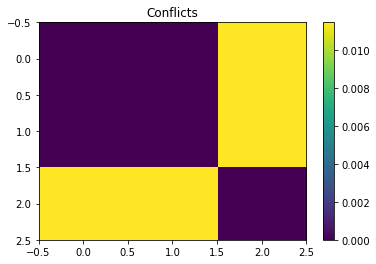

In [19]:
from  metal.contrib.visualization.analysis import view_conflicts

# Viewing conflicts
for j in range(NUM_TASKS):
    view_conflicts(Ls[1][j], normalize=True)

In [20]:
# Define task graph
# Reference: https://github.com/HazyResearch/metal/blob/master/tutorials/Multitask.ipynb
'''
column_names = ['multiclass_label_abnormal', multiclass_label_seizure', 'multiclass_label_slowing', 'multiclass_label_spikes', 
               'multiclass_label_sharps', 'multiclass_label_suppression', 'multiclass_label_discont',
               'multiclass_label_hypsar', 'multiclass_label_seizure_motor', 'multiclass_label_seizure_hyperkinetic',
               'multiclass_label_seizure_clonic', 'multiclass_label_seizure_tonic']
'''
from metal.multitask.task_graph import TaskHierarchy

# edges: which task is which task's parent?
cardinalities = [2] + [2] * (NUM_TASKS-1)
print('Cardinalties:{}'.format(cardinalities))

edges = [(0,1), (0,2), (0,3), (0,4), (0,5), (0,6), 
         (0,7), (0,8), (0,9), (0,10), (0,11)] # task 0 is parent of all other tasks
task_graph = TaskHierarchy(cardinalities=cardinalities, edges=edges)

Cardinalties:[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [26]:
#from metal.utils import LogWriter
from metal.tuners import RandomSearchTuner
from metal.multitask import MTLabelModel

# Creating metal label model
#label_model = MTLabelModel(K=cardinalities, task_graph=task_graph)
label_model = MTLabelModel(K=cardinalities, task_graph=None)

In [27]:
%%time
# Training label model
label_model.train_model(Ls[0], n_epochs=200, log_train_every=20, seed=123)

Computing O...
Estimating \mu...


Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x149f97c50>
Traceback (most recent call last):
  File "/Users/siyitang/.local/lib/python3.6/site-packages/tqdm/_tqdm_notebook.py", line 226, in __iter__
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/siyitang/anaconda/envs/metal/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1302, in time
    out = eval(code, glob, local_ns)
  File "<timed eval>", line 2, in <module>
  File "/Users/siyitang/Dropbox/Github/metal/metal/label_model/label_model.py", line 446, in train_model
    self._train_model(train_loader, partial(self.loss_mu, l2=l2))
  File "/Users/siyitang/Dropbox/Github/metal/metal/classifier.py", line 241, in _train_model
    loss = loss_fn(*data)
  File "/Users/siyitang/Dropbox/Github/metal/metal/label_model/label_model.py", line 330, in loss_mu
    return loss_1 + loss_2 + self.loss_l2(l2=l2)
  File "/Users/siyitang/Dropbox/Github/metal/metal/label_model/label_model.py", line 312, in loss_l2
    D = l2 * torch.eye(self.d)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/siyitang/anaconda/envs/metal/lib/python3.6/site-p

KeyboardInterrupt: 

In [32]:
print('L dev length:{}'.format(len(Ls[1])))
print('L test length:{}'.format(len(Ls[2])))

print('L dev task 0 shape:{}'.format(Ls[1][0].shape))
print('L test task 0 shape:{}'.format(Ls[2][0].shape))

print('Y dev task 0 shape:{}'.format(Ys[1][0].shape))
print('Y test task 0 shape:{}'.format(Ys[2][0].shape))

L dev length:12
L test length:12
L dev task 0 shape:(262, 3)
L test task 0 shape:(263, 3)
Y dev task 0 shape:(262,)
Y test task 0 shape:(263,)


In [24]:
import ipdb; ipdb.set_trace()

label_model.score((Ls[1], Ys[1]))

--Return--
None
> <ipython-input-24-aaad3ce07781>(1)<module>()
----> 1 import ipdb; ipdb.set_trace()
      2 
      3 label_model.score((Ls[1], Ys[1]))

ipdb> Ls[1]
[<262x3 sparse matrix of type '<class 'numpy.int64'>'
	with 581 stored elements in Compressed Sparse Row format>, <262x3 sparse matrix of type '<class 'numpy.int64'>'
	with 608 stored elements in Compressed Sparse Row format>, <262x3 sparse matrix of type '<class 'numpy.int64'>'
	with 595 stored elements in Compressed Sparse Row format>, <262x3 sparse matrix of type '<class 'numpy.int64'>'
	with 556 stored elements in Compressed Sparse Row format>, <262x3 sparse matrix of type '<class 'numpy.int64'>'
	with 533 stored elements in Compressed Sparse Row format>, <262x3 sparse matrix of type '<class 'numpy.int64'>'
	with 502 stored elements in Compressed Sparse Row format>, <262x3 sparse matrix of type '<class 'numpy.int64'>'
	with 509 stored elements in Compressed Sparse Row format>, <262x3 sparse matrix of type '<class 'numpy

ipdb> c


IndexError: index 2 is out of bounds for axis 1 with size 2

In [ ]:
len(Ls[0])

In [25]:
Y_train_ps = label_model.predict_proba(Ls[0])

IndexError: index 2 is out of bounds for axis 1 with size 2

In [ ]:
label_model.score((Ls[1], Ys[1]))

# Load trained label model

In [ ]:
import pickle
model_dir = '/home/tsy935/output/eeg_reports/label_model'
Y_train_ps_dir = '/home/tsy935/output/eeg_reports/Y_train_ps'
with open(Y_train_ps_dir, 'rb') as f:
    Y_train_ps = pickle.load(f)

print(len(Y_train_ps))
print(Y_train_ps[0].shape)

In [ ]:
# Getting probabilistic training labels
# Y_train_ps stands for "Y[labels]_train[split]_p[redicted]s[oft]"
Y_train_ps = label_model.predict_proba(Ls[0])
Y_dev_ps = label_model.predict_proba(Ls[1])
Y_test_ps = label_model.predict_proba(Ls[2])
Y_ps = [Y_train_ps, Y_dev_ps, Y_test_ps]